In [17]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import ipywidgets as wg

In [18]:
def Gaussian(x, s):
    """Calculates a Gaussian enveloppe for an array of positions.

    Args:
        x (array): positions.
        s (float): standard deviation.

    Returns:
        (array): Gaussian values at x."""

    G = 1 / np.sqrt(s * np.sqrt(2 * np.pi)) * np.exp(-(x**2) / (4 * s**2))

    return G


def Exponential(x, gamma):
    """Calculates an Exponential enveloppe for an array of positions.

    Args:
        x (array): positions.
        gamma (float): exponential parameter.

    Returns:
        (array): Exponential values at x."""

    E = (gamma) ** (1 / 2) * np.exp(-gamma * x / 2) * np.heaviside(x, 1)

    return E


def Overlap(x1, x2, param, env_type):
    """Calculates the overlap integral between 2 wave functions with shifts x1 and x2.

    Args:
        x1 (float): shift value for wave function 1.
        x2 (float): shift value for wave function 2..
        params (list): parameters for gaussian or exponential shapes (sigma and gamma respectively)
        env_type (int): wave function envelope shape (1 = Gaussian, 2 = Exponential)

    Returns:
        (float): Overlap integral value."""

    if env_type == 1:
        OverLap = np.exp(-((x1 - x2) ** 2) / (8 * param**2))
    if env_type == 2:
        OverLap = np.exp(-abs(x1 - x2) * param / 2)

    return OverLap

### Initializing nonorthogonal functions
In this simulation, the wave enveloppes could be either Gaussian or exponential :

$$\psi(x) = \frac{1}{\sqrt{\sigma\sqrt{2\pi}}}\exp{\left(-\frac{x^2}{4\sigma^2}\right)} \hspace{12pt} \textrm{or} \hspace{12pt} \psi(x) = \sqrt{\gamma}\exp{\left(-\frac{\gamma}{2}x\right)}u(x)$$

Let $\psi_i$ be a wave function with a shift $x_i$, which means : $\psi_i(x)=\psi(x-x_i)$

The overlap between two shifted functions is given by :

$$\langle\psi_i|\psi_j\rangle=\int\psi_i^*(x)\psi_j(x)dx=\int\psi^*(x-x_i)\psi(x-x_j)dx$$

we can calculate the overlap function for any shifts $x_i$ and $x_j$:

for Gaussian functions: $\langle\psi_i|\psi_j\rangle=\exp{\left(-\frac{(x_i-x_j)^2}{8\sigma^2}\right)}$

and for exponential functions:$\langle\psi_i|\psi_j\rangle=\exp{\left(-\frac{1}{2}|x_i-x_j|\gamma\right)}$



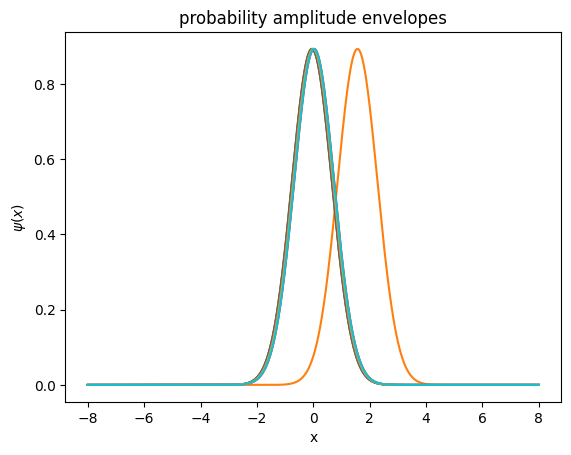

In [20]:
env_type = 1  # 1=Gaussian, 2=exponential
N = 10000000  # number of x points to plot the wave functions
N_shift = 10  # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

if env_type == 1:
    sigma_wave = 0.5  # standard deviation of wave function
    param = sigma_wave
    x = np.linspace(-16 * sigma_wave, +16 * sigma_wave, N)  # position values
    param_shift = (
        sigma_wave / 20
    )  # standard deviation of shift values (we assume that the shift is normally distributed)
    x_shift = np.random.standard_cauchy(N_shift) * param_shift  # shift values

    for i in range(N_shift):
        waves[i] = Gaussian(x - x_shift[i], sigma_wave)

if env_type == 2:
    gamma_wave = 0.5
    param = gamma_wave
    x = np.linspace(-5 / gamma_wave, 15 / gamma_wave, N)  # position values
    param_shift = 1 / (gamma_wave * 2)
    x_shift = np.random.standard_cauchy(N_shift) * param_shift  # shift values

    for i in range(N_shift):
        waves[i] = Exponential(x - x_shift[i], gamma_wave)


# plotting wave functions
plt.plot(x, waves.T)
plt.xlabel("x")
plt.ylabel(r"$\psi (x)$")
plt.title("probability amplitude envelopes")
plt.show()

### Building orthogonal base
The wave functions generated above are not orthogonal, will we use Lowdin orthogonolization to obtain a orthonormal basis $\left\{|\theta_n\rangle\right\}$ with which we can describe our original functions $\left\{|\psi_n\rangle\right\}$. For this we use the following relation :

$$\vec{|\theta\rangle} = S^{-\frac{1}{2}}\vec{|\psi\rangle} \hspace{12pt} \textrm{where} \hspace{12pt} \vec{|\psi\rangle} =\begin{pmatrix}
                        |\psi_1\rangle\\
                        |\psi_2\rangle\\
                        \vdots\\
                        |\psi_N\rangle
                        \end{pmatrix} \hspace{12pt} \textrm{and} \hspace{12pt} \vec{|\theta\rangle} =\begin{pmatrix}
                        |\theta_1\rangle\\
                        |\theta_2\rangle\\
                        \vdots\\
                        |\theta_N\rangle
                        \end{pmatrix}  $$

$S$ is the overlap transfer matrix where $S_{ij}=\langle\psi_i|\psi_j\rangle$, and $S^{-\frac{1}{2}}$ is the inverse of $S^{\frac{1}{2}}$ which is given as :

$$S^{\frac{1}{2}}=U\sqrt{S_{\textrm{diag}}}U^\dag$$

$\sqrt{S_{\textrm{diag}}}$ is obtained by diagonalizing $S$ $\left(\textrm{i.e. }S_{\textrm{diag}}=U^\dag S U\right)$ and replacing the elements of the diagonal by their square roots.

In [ ]:
# Overlap matrix S
S = np.zeros((N_shift, N_shift))
for i in range(N_shift):
    S[i, i] = 1
    for j in range(i):
        S[i, j] = Overlap(x_shift[i], x_shift[j], param, env_type)
        S[j, i] = S[i, j]

# Finding eigenvalues + eigenvectors
eigenvals, U = np.linalg.eigh(S)

S_diag = np.eye(N_shift)
for i in range(N_shift):
    S_diag[i, i] = abs(eigenvals[i])

# Calculating new wave functions
U = np.matrix(U)
S_sqrt = np.matmul(np.matmul(U, np.sqrt(S_diag)), U.H)
S_sqrt_inv = np.linalg.inv(S_sqrt)
new_base = np.array(np.matmul(S_sqrt_inv, waves))

# Plotting new wave functions
""" plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, waves.T)
plt.xlabel("x")
plt.ylabel(r"$\psi (x)$")
plt.title("probability amplitude envelopes")
plt.subplot(1, 2, 2)
plt.plot(x, new_base.T)
plt.xlabel("x")
plt.ylabel(r"$\theta(x)$")
plt.title("New orthogonal base functions")
# plt.xlim((-0.5,1.2))
plt.savefig('lowdin.png')
plt.show() """

' plt.figure(figsize=(10, 5))\nplt.subplot(1, 2, 1)\nplt.plot(x, waves.T)\nplt.xlabel("x")\nplt.ylabel(r"$\\psi (x)$")\nplt.title("probability amplitude envelopes")\nplt.subplot(1, 2, 2)\nplt.plot(x, new_base.T)\nplt.xlabel("x")\nplt.ylabel(r"$\theta(x)$")\nplt.title("New orthogonal base functions")\n# plt.xlim((-0.5,1.2))\nplt.savefig(\'lowdin.png\')\nplt.show() '

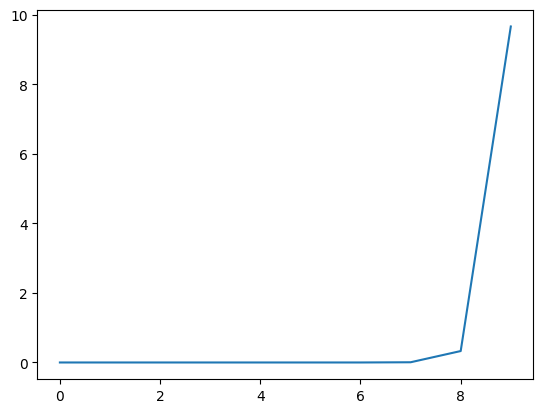

In [ ]:
S_diag
plt.plot(np.diag(S_diag))
S_sqrt=np.array(S_sqrt)
S_sqrt_inv=np.array(S_sqrt_inv)


### Checking Orthogonality and normalization

In [ ]:
for i in range(N_shift):
    for j in range(i):
        over = sc.integrate.simps(new_base[i] * new_base[j], x)
        print(f"overlap between wave function {i} and wave function {j} : {over}")
    over = sc.integrate.simps(new_base[i] * new_base[i], x)
    print(f"overlap between wave function {i} and wave function {i} : {over}")

overlap between wave function 0 and wave function 0 : 0.42020007458404324
overlap between wave function 1 and wave function 0 : 0.19299813700607546
overlap between wave function 1 and wave function 1 : 0.28252062595702804
overlap between wave function 2 and wave function 0 : -0.05180971980124784
overlap between wave function 2 and wave function 1 : 0.17234341543810852
overlap between wave function 2 and wave function 2 : 0.38721652485367025
overlap between wave function 3 and wave function 0 : -2.483583584710493e-06
overlap between wave function 3 and wave function 1 : 2.4974171633822894e-06
overlap between wave function 3 and wave function 2 : -1.513036261936705e-06
overlap between wave function 3 and wave function 3 : 0.9999999999474322
overlap between wave function 4 and wave function 0 : -0.08242409512022437
overlap between wave function 4 and wave function 1 : 0.17521180309464554
overlap between wave function 4 and wave function 2 : 0.41167578255036935
overlap between wave functio

In [ ]:
def lowdin(N_shift):
    N_shift=int(N_shift)
    env_type = 1  # 1=Gaussian, 2=exponential
    N = 500  # number of x points to plot the wave functions

    waves = np.zeros((N_shift, N))  # values for each wave function

    if env_type == 1:
        sigma_wave = 0.5  # standard deviation of wave function
        param = sigma_wave
        x = np.linspace(-8 * sigma_wave, 8 * sigma_wave, N)  # position values
        param_shift = (
            sigma_wave / 10
        )  # standard deviation of shift values (we assume that the shift is normally distributed)
        x_shift = np.random.standard_cauchy(N_shift) * param_shift  # shift values

        for i in range(N_shift):
            waves[i] = Gaussian(x - x_shift[i], sigma_wave)

    if env_type == 2:
        gamma_wave = 0.5
        param = gamma_wave
        x = np.linspace(-5 / gamma_wave, 15 / gamma_wave, N)  # position values
        param_shift = 1 / (gamma_wave * 2)
        x_shift = np.random.standard_cauchy(N_shift) * param_shift  # shift values

        for i in range(N_shift):
            waves[i] = Exponential(x - x_shift[i], gamma_wave)
    
    # Overlap matrix S
    S = np.zeros((N_shift, N_shift))
    for i in range(N_shift):
        S[i, i] = 1
        for j in range(i):
            S[i, j] = Overlap(x_shift[i], x_shift[j], param, env_type)
            S[j, i] = S[i, j]

    # Finding eigenvalues + eigenvectors
    eigenvals, U = np.linalg.eigh(S)

    S_diag = np.eye(N_shift)
    for i in range(N_shift):
        S_diag[i, i] = abs(eigenvals[i])

    # Calculating new wave functions
    U = np.matrix(U)
    S_sqrt = np.matmul(np.matmul(U, np.sqrt(S_diag)), U.H)
    S_sqrt_inv = np.linalg.inv(S_sqrt)
    new_base = np.array(np.matmul(S_sqrt_inv, waves))

    # Plotting new wave functions
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, waves.T)
    plt.xlabel("x")
    plt.ylabel(r"$\psi (x)$")
    plt.title("probability amplitude envelopes")
    plt.subplot(1, 2, 2)
    plt.plot(x, new_base.T)
    plt.xlabel("x")
    plt.ylabel(r"$\theta(x)$")
    plt.title("New orthogonal base functions")
    # plt.xlim((-0.5,1.2))
    #plt.savefig('lowdin.png')
    #plt.show()

N_shift=2
N_shift_slide = wg.FloatSlider(value=N_shift,min=2,max=10,step=1)
wg.interact(lowdin, N_shift=N_shift_slide)


interactive(children=(FloatSlider(value=2.0, description='N_shift', max=10.0, min=2.0, step=1.0), Output()), _…

<function __main__.lowdin(N_shift)>